# Face Expression Detection

## Libraries



In [ ]:
import os
import glob
import random
import itertools

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

import keras
import tensorflow as tf

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix

from google.colab import files

In [ ]:
seed_value= 0

os.environ['PYTHONHASHSEED']=str(seed_value)  # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
random.seed(seed_value)  # 2. Set `python` built-in pseudo-random generator at a fixed value
np.random.seed(seed_value)  # 3. Set `numpy` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)  # 4. Set the `tensorflow` pseudo-random generator at a fixed value

In [ ]:
font_size = 16

plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['axes.linewidth'] = 1.25
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

plt.rcParams['xtick.major.size'] = 4
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['ytick.major.width'] = 1.2

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['tab:blue', 'tab:red', 'black']) 

<br>

## Running GPU on Colab

To ensure that GPU is running on this Colab notebook, we can follow the steps below:

1. Colab Menu: Select "Runtime"
2. "Change runtime type"
3. For "Hardware Accelerator", select "GPU"
4. Save

In [ ]:
# Confirm that GPU is running
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

<br>

## Getting the Data

### Authenticating with Kaggle using kaggle.json

To retrieve the datasets, we need navigate to [Kaggle](https://www.kaggle.com) and sign in to our account. Then, we go to the [Account tab of our user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing our API credentials.

Finally, we need to run the cell below to upload kaggle.json to our Colab runtime.

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


<br>

### Face Expression Recognition Dataset

In [ ]:
!kaggle datasets download jonathanoheix/face-expression-recognition-dataset

 92% 111M/121M [00:00<00:00, 254MB/s] 
100% 121M/121M [00:00<00:00, 227MB/s]


In [ ]:
%%capture
!unzip face-expression-recognition-dataset.zip

<br>

### CK+ Dataset

In [ ]:
!kaggle datasets download shawon10/ckplus

  0% 0.00/3.63M [00:00<?, ?B/s]
100% 3.63M/3.63M [00:00<00:00, 231MB/s]


In [ ]:
%%capture
!unzip ckplus.zip

<br>

### Mixing the Datasets

In [ ]:
!rm /content/face-expression-recognition-dataset.zip
!rm /content/ckplus.zip

%rm -rf /content/images/images
%rm -rf /content/ck

In [ ]:
!mv "/content/CK+48/anger"/* "/content/images/train/angry"
!mv "/content/CK+48/disgust"/* "/content/images/train/disgust"
!mv "/content/CK+48/fear"/* "/content/images/train/fear"
!mv "/content/CK+48/happy"/* "/content/images/train/happy"
!mv "/content/CK+48/sadness"/* "/content/images/train/sad"
!mv "/content/CK+48/surprise"/* "/content/images/train/surprise"

<br>

## Data Visualisation

In [ ]:
base_path = r'/content/images/'

In [ ]:
emotions_list = os.listdir(base_path + 'train/')
emotions_list = sorted(emotions_list)

print('Emotions:\n', *emotions_list, sep='\n  ')

Emotions:

  angry
  disgust
  fear
  happy
  neutral
  sad
  surprise


In [ ]:
num_classes = len(emotions_list)

In [ ]:
print('Number of images in folders:')
print('     Train: ', len(glob.glob("/content/images/train/*/*.jpg")))
print('Validation: ', len(glob.glob("/content/images/validation/*/*.jpg")))

Number of images in folders:
     Train:  28821
Validation:  7066


In [ ]:
path = base_path + 'train/'
number_of_files = [len(os.listdir(path + '{}/'.format(emotion))) for emotion in emotions_list]

df = pd.DataFrame({
    'Emotion': [emotion.title() for emotion in emotions_list],
    'Count': number_of_files
})
df.sort_values(by='Count', ascending=False, inplace=True)

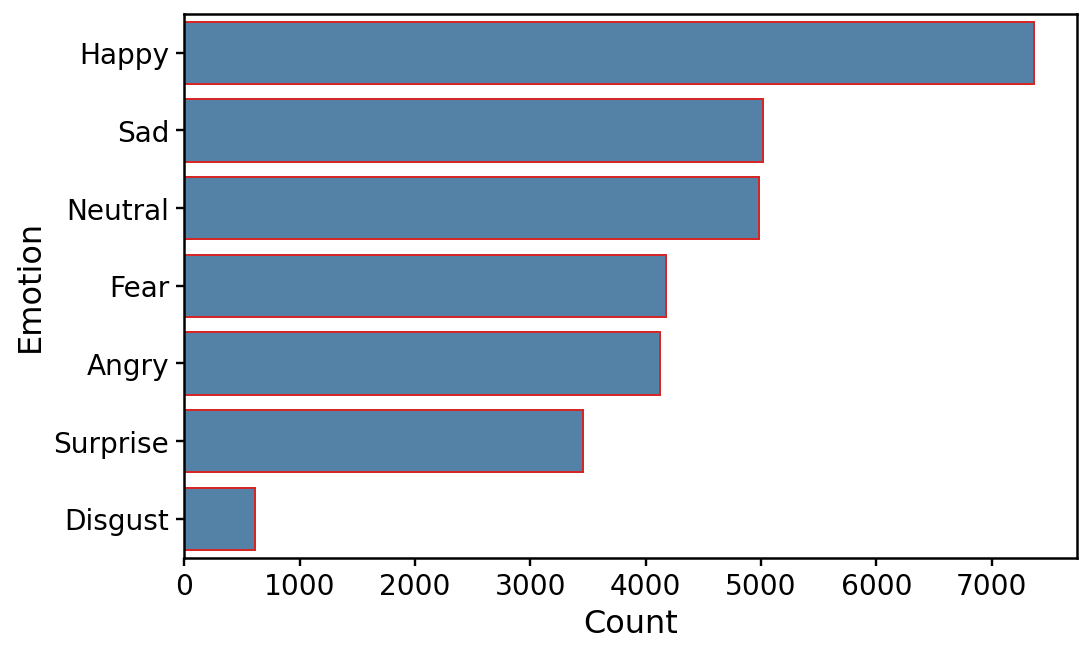

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.barplot(y='Emotion', x='Count', color='steelblue', edgecolor='tab:red', data=df)

plt.show()

In [ ]:
img_depth = 1
img_width, img_height = 48, 48

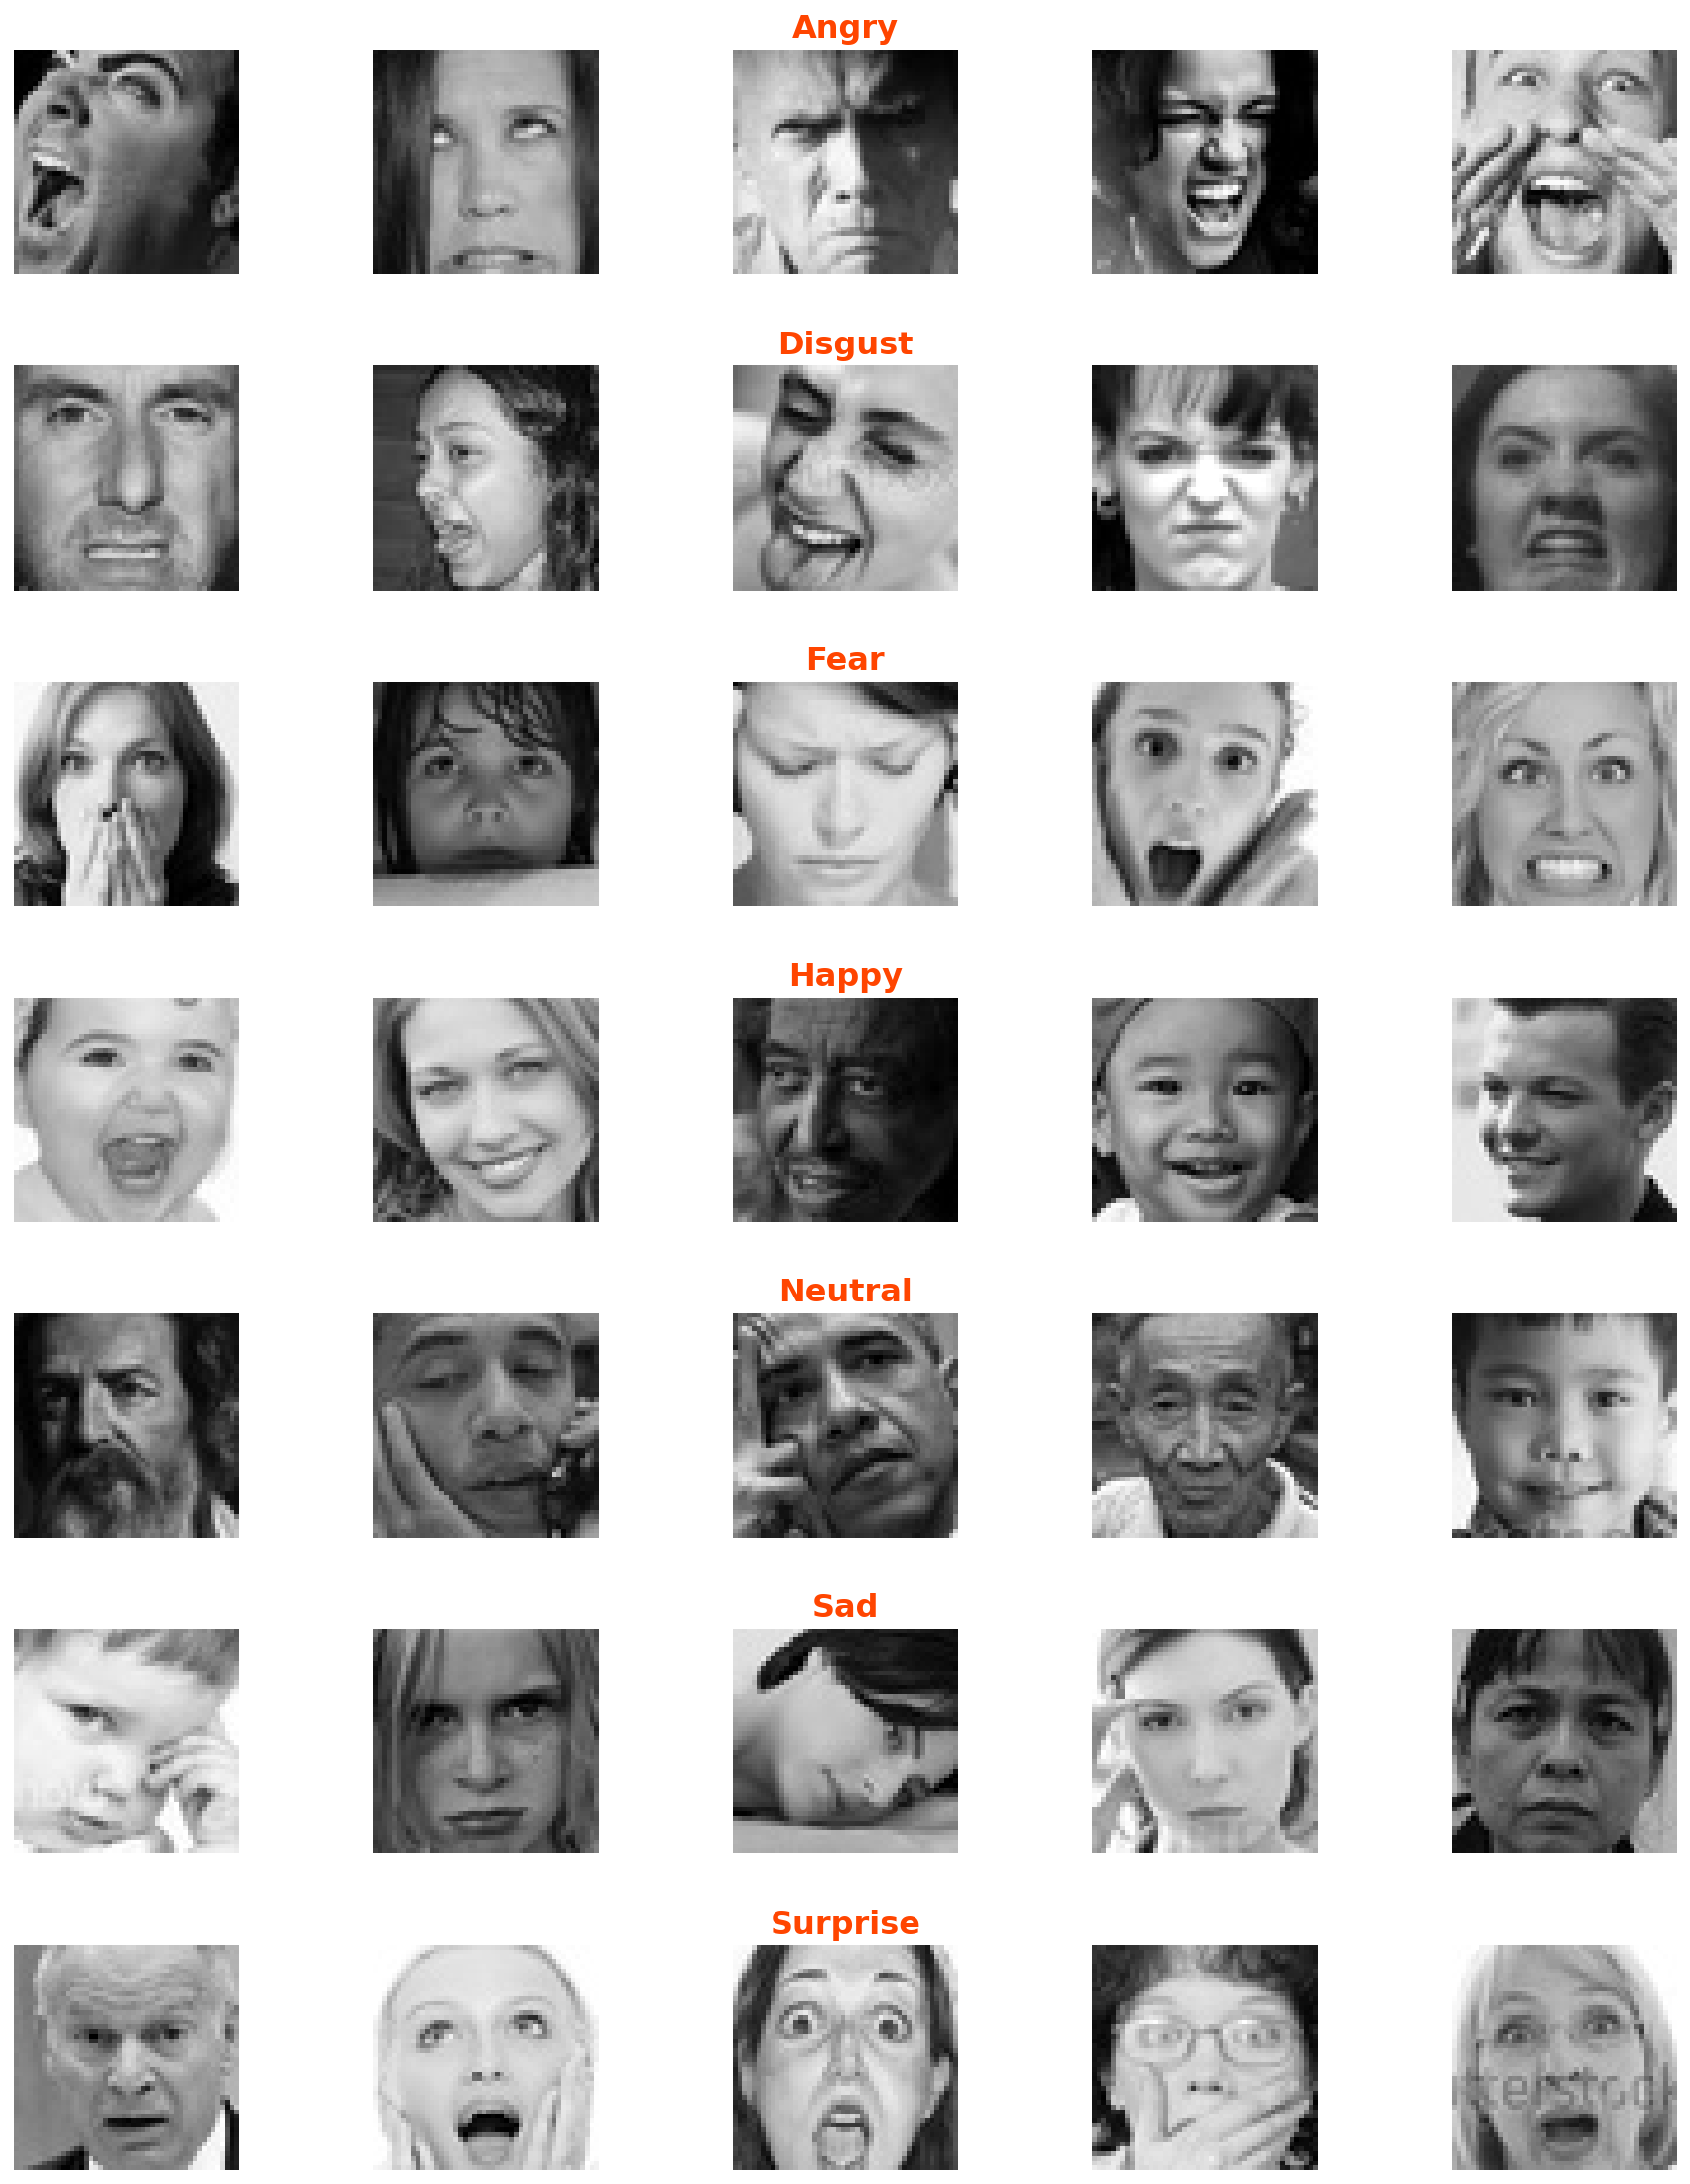

In [ ]:
fig = plt.figure(0, figsize=(15, 20))

index = 1
for emotion in emotions_list:
    path = base_path + 'train/{}'.format(emotion)
    file_numbers = os.listdir(path)
    random_files = np.random.choice(file_numbers, size=5, replace=False)

    for i, random_file in enumerate(random_files):
        img = load_img(path= base_path + 'train/{}/{}'.format(emotion, random_file),
                       target_size=(img_width, img_height))

        plt.subplot(7, 5, index)

        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if i == 2: plt.title(emotion.title(), color='orangered', weight='bold')
        index += 1

fig.subplots_adjust(wspace=0.6)
plt.show()

<br>

## Image Augmentation

In [ ]:
batch_size = 32

datagen_train = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    fill_mode='nearest',
    horizontal_flip=True,
    rescale=1./255,
)
datagen_validation = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(directory=base_path + 'train',
                                                    target_size=(img_width, img_height),
                                                    color_mode='grayscale',
                                                    class_mode='categorical',
                                                    batch_size=batch_size,
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(directory=base_path + 'validation',
                                                    target_size=(img_width, img_height),
                                                    color_mode='grayscale',
                                                    class_mode='categorical',
                                                    batch_size=batch_size,
                                                    shuffle=True)

Found 29748 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


<br>

## Creating the Model

In [ ]:
model = Sequential(name='CNN_Model')

### Block #01
model.add(
    Conv2D(filters=64,
           kernel_size=(5, 5),
           input_shape=(img_width, img_height, img_depth),
           activation='elu',
           padding='same',
           kernel_initializer='he_normal',
           name='Conv2D_01'))
model.add(BatchNormalization(name='BatchNorm_01'))

model.add(
    Conv2D(filters=64,
           kernel_size=(5, 5),
           activation='elu',
           padding='same',
           kernel_initializer='he_normal',
           name='Conv2D_02'))
model.add(BatchNormalization(name='BatchNorm_02'))

model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPool2D_01'))
model.add(Dropout(0.4, name='Dropout_01'))


### Block #02
model.add(
    Conv2D(filters=128,
           kernel_size=(3, 3),
           activation='elu',
           padding='same',
           kernel_initializer='he_normal',
           name='Conv2D_03'))
model.add(BatchNormalization(name='BatchNorm_03'))

model.add(
    Conv2D(filters=128,
           kernel_size=(3, 3),
           activation='elu',
           padding='same',
           kernel_initializer='he_normal',
           name='Conv2D_04'))
model.add(BatchNormalization(name='BatchNorm_04'))

model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPool2D_02'))
model.add(Dropout(0.4, name='Dropout_02'))


### Block #03
model.add(
    Conv2D(filters=256,
           kernel_size=(3, 3),
           activation='elu',
           padding='same',
           kernel_initializer='he_normal',
           name='Conv2D_05'))
model.add(BatchNormalization(name='BatchNorm_05'))

model.add(
    Conv2D(filters=256,
           kernel_size=(3, 3),
           activation='elu',
           padding='same',
           kernel_initializer='he_normal',
           name='Conv2D_06'))
model.add(BatchNormalization(name='BatchNorm_06'))

model.add(MaxPooling2D(pool_size=(2, 2), name='MaxPool2D_03'))
model.add(Dropout(0.5, name='dropout_03'))


### Block #04
model.add(Flatten(name='flatten'))

model.add(
    Dense(128,
          activation='elu',
          kernel_initializer='he_normal',
          name='Dense_01'))
model.add(BatchNormalization(name='BatchNorm_07'))

model.add(Dropout(0.6, name='Dropout_04'))

### Output Layer
model.add(Dense(num_classes, activation='softmax', name='Output'))

model.summary()

Model: "CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_01 (Conv2D)          (None, 48, 48, 64)        1664      
                                                                 
 BatchNorm_01 (BatchNormaliz  (None, 48, 48, 64)       256       
 ation)                                                          
                                                                 
 Conv2D_02 (Conv2D)          (None, 48, 48, 64)        102464    
                                                                 
 BatchNorm_02 (BatchNormaliz  (None, 48, 48, 64)       256       
 ation)                                                          
                                                                 
 MaxPool2D_01 (MaxPooling2D)  (None, 24, 24, 64)       0         
                                                                 
 Dropout_01 (Dropout)        (None, 24, 24, 64)        0 

<br>

## Compiling the Model

In [ ]:
# optim = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam')
optim = tf.keras.optimizers.Adam(learning_rate=0.001, name='Adam')

model.compile(loss='categorical_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])

<br>

## Training the Model

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0.0001,
                               patience=10,
                               verbose=1,
                               restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy',
                                 factor=0.5,
                                 patience=7,
                                 verbose=1,
                                 min_lr=1e-7)

In [ ]:
batch_size = 32
epochs = 100

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n//train_generator.batch_size,
                              epochs=epochs,
                              validation_data = validation_generator,
                              validation_steps = validation_generator.n//validation_generator.batch_size,
                              callbacks=[early_stopping, lr_scheduler])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


929/929 [==============================] - 66s 56ms/step - loss: 2.1036 - accuracy: 0.2300 - val_loss: 1.6352 - val_accuracy: 0.3577 - lr: 0.0010
Epoch 2/100
929/929 [==============================] - 50s 54ms/step - loss: 1.6600 - accuracy: 0.3464 - val_loss: 1.4947 - val_accuracy: 0.4402 - lr: 0.0010
Epoch 3/100
929/929 [==============================] - 49s 53ms/step - loss: 1.4832 - accuracy: 0.4285 - val_loss: 1.2902 - val_accuracy: 0.5033 - lr: 0.0010
Epoch 4/100
929/929 [==============================] - 49s 52ms/step - loss: 1.3915 - accuracy: 0.4679 - val_loss: 1.3016 - val_accuracy: 0.5034 - lr: 0.0010
Epoch 5/100
929/929 [==============================] - 49s 53ms/step - loss: 1.3299 - accuracy: 0.4893 - val_loss: 1.1970 - val_accuracy: 0.5374 - lr: 0.0010
Epoch 6/100
929/929 [==============================] - 48s 52ms/step - loss: 1.2799 - accuracy: 0.5143 - val_loss: 1.1166 - val_accuracy: 0.5820 - lr: 0.0010
Epoch 7/100
929/929 [==============================] - 48s 52ms/

<br>

## Learning Curves

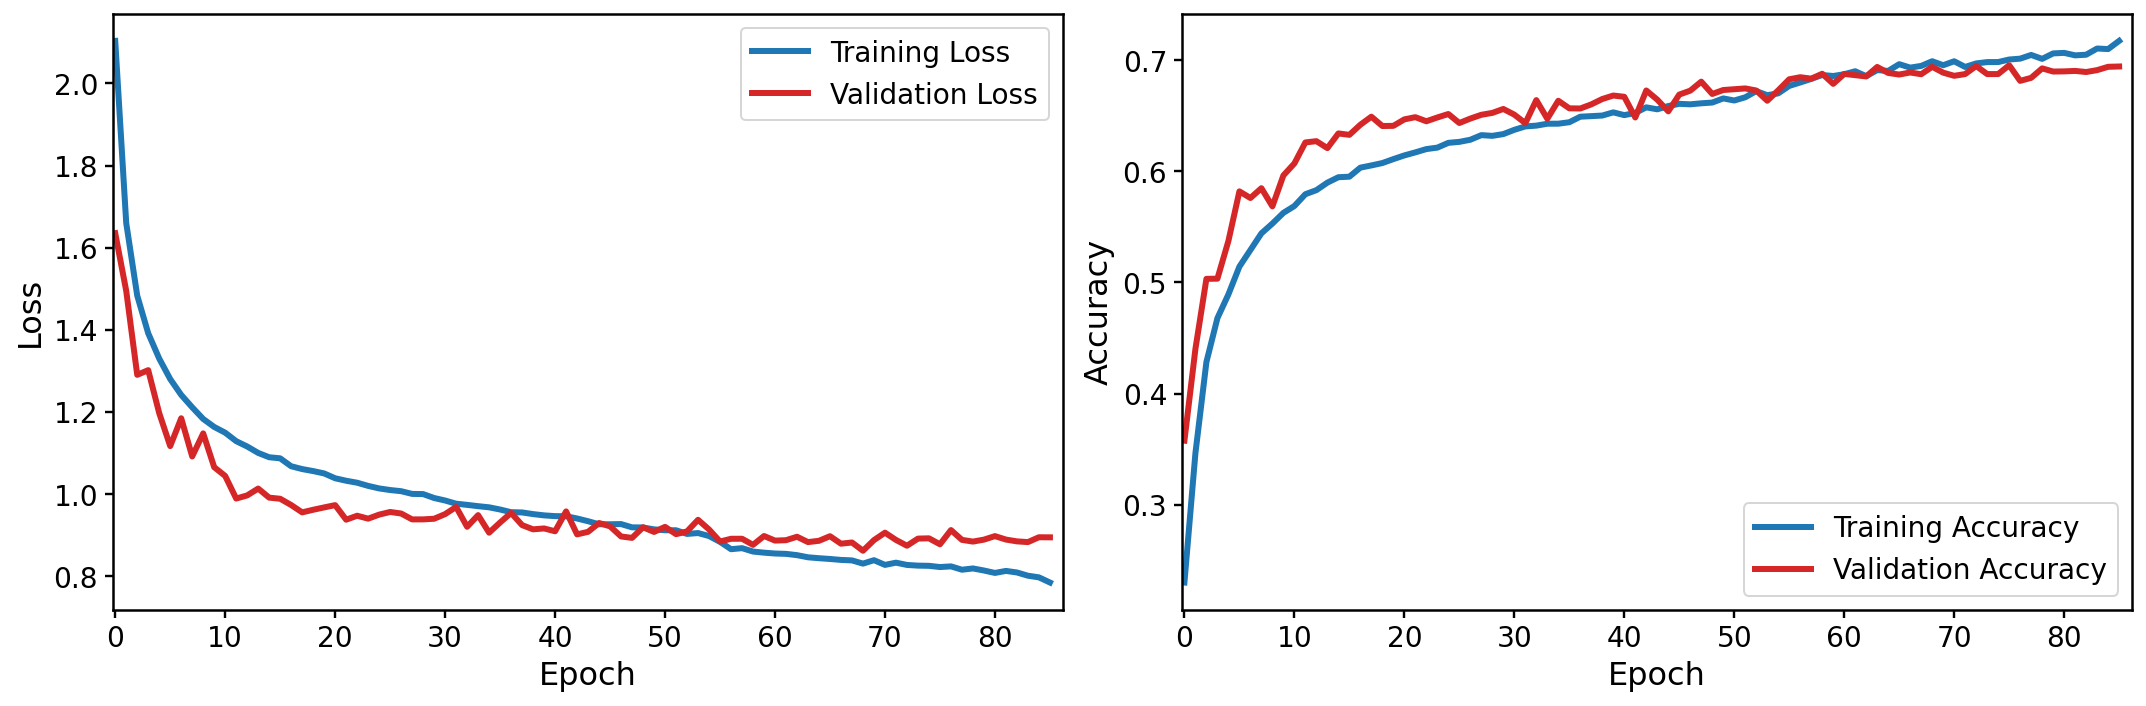

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')

for ax in [ax1, ax2]:
  ax.set_xlabel('Epoch')
  ax.set_xlim(left=-0.2, right=len(history.history['loss']) + 0.2)
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

<br>

## Predictions

In [ ]:
model.save('model.h5')

In [ ]:
loaded_model = keras.models.load_model('/content/model.h5')

In [ ]:
predictions = loaded_model.predict_generator(generator=validation_generator)
classes = validation_generator.class_indices.keys()

print(classes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


dict_keys(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])


In [ ]:
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes

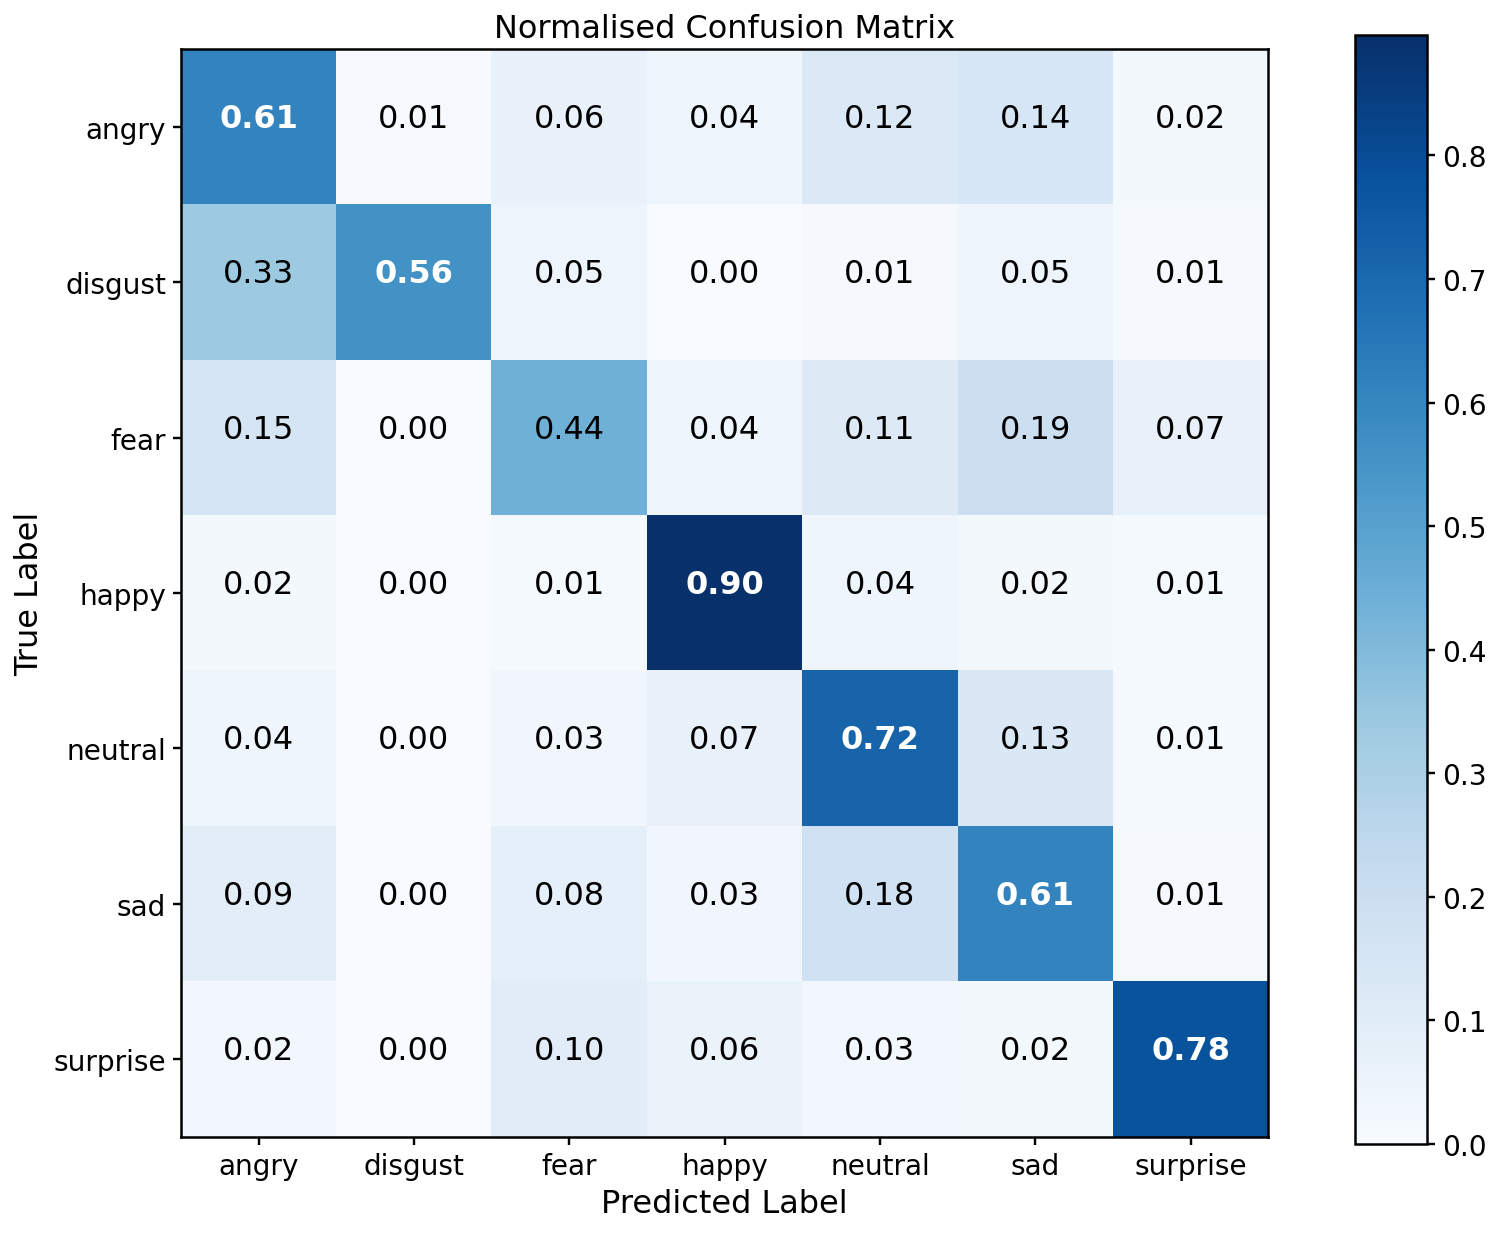

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

fig, ax = plt.subplots(figsize=(10, 10))

im=ax.imshow(cm, interpolation='nearest', cmap='Blues')

ax.set(title='Normalised Confusion Matrix',
       xlabel='Predicted Label',
       ylabel='True Label')

tick_marks = np.arange(len(classes))
ax.set_xticks(tick_marks)
ax.set_xticklabels(classes, rotation=0)
ax.set_yticks(tick_marks)
ax.set_yticklabels(classes)

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(x=j,
           y=i,
           s=format(cm[i, j], '.2f'),
           fontsize=16,
           ha='center',
           color='w' if cm[i, j] > thresh else 'k',
           weight='bold' if cm[i, j] > thresh else 'normal')

cax = plt.axes([0.95, 0.12, 0.05, 0.77])
plt.colorbar(mappable=im, cax=cax)

plt.show()

<br>

---

<br>

In [ ]:
def predict_single_img(emotion, file_name):
    img = load_img(path=base_path + 'validation/{}/{}'.format(emotion, file_name),
                   target_size=(pic_size, pic_size))

    img = img_to_array(img) / 255
    img_tensor = tf.image.rgb_to_grayscale(img)

    img_tensor = np.expand_dims(img_tensor, axis=0)

    classes = loaded_model.predict(img_tensor)

    return img, classes

In [ ]:
def plot_wrong_preds(emotion):
    nrows, ncols = 2, 5;
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (14, 7))
    ax = ax.flatten()
    
    path = base_path + 'validation/{}'.format(emotion)
    file_names = os.listdir(path)
    
    index = 0
    for file_name in file_names:
        img, classes = predict_single_img(emotion, file_name)
        label = list(class_names)[classes.argmax()]
        
        if label != emotion:
            ax[index].imshow(img)
            ax[index].text(23, -2, f"Label: {emotion}", fontsize=11, c='g', ha='right')
            ax[index].text(22, -2, " | ", fontsize=16, color='k')
            ax[index].text(25.6, -2, f"Pred.: {label}", fontsize=11, c ='r', ha='left')
            
            ax[index].axis('off')
            index += 1
            
        if index == nrows*ncols: break
            
    plt.tight_layout()

In [ ]:
plot_wrong_preds('neutral')

In [ ]:
plot_wrong_preds('sad')